# Doom Basic with Advantage Actor Critic

The purpose of the scenario is just to check if using this framework to train some AI in a 3D environment is feasible.

### Enviroment:

Map is a rectangle with gray walls, ceiling and floor. Player is spawned along the longer wall, in the center. A red, circular monster is spawned randomly somewhere along the opposite wall. Player can only (config) go left/right and shoot. 1 hit is enough to kill the monster. Episode finishes when monster is killed or on timeout.

### Actions:
 - MOVE LEFT
 - MOVE RIGHT
 - ATTACK

### REWARDS:
 - +101 for killing the monster 
 - -1 for living
 - -5 for missing a shot

## Step 1: Import the libraries

In [1]:
import numpy as np
import time
import os
import torch
from vizdoom import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import namedtuple, deque

%matplotlib inline
os.environ["WANDB_NOTEBOOK_NAME"] = "basic.ipynb"

C:\Users\paolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
from a2c_agent import A2CAgent
from stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [3]:
def create_environment():
    game = DoomGame()
    
    # Load the correct configuration
    game.load_config("../doom files/basic.cfg")
    
    # Load the correct scenario (in our case defend_the_center scenario)
    game.set_doom_scenario_path("../doom files/basic.wad")
    
    possible_actions  = np.identity(3,dtype=int).tolist()
    
    return game, possible_actions
game, possible_actions = create_environment()

In [4]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Step 3: Viewing our Enviroment

The size of frame is: ( 240 ,  320 )
No. of Actions:  [[1, 0, 0], [0, 1, 0], [0, 0, 1]]


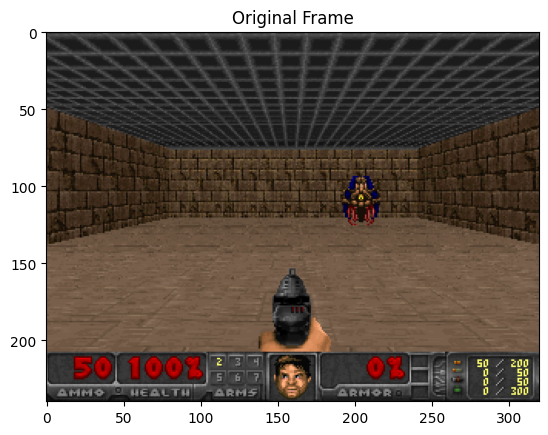

In [5]:
print("The size of frame is: (", game.get_screen_height(), ", ", game.get_screen_width(), ")")
print("No. of Actions: ", possible_actions)
game.init()
plt.figure()
plt.imshow(game.get_state().screen_buffer.transpose(1, 2, 0))
plt.title('Original Frame')
plt.show()
game.close()

### Execute the code cell below to play with a random policy.

In [6]:
def random_play():
    game.init()
    game.new_episode()
    score = 0
    while True:
        reward = game.make_action(possible_actions[np.random.randint(3)])
        done = game.is_episode_finished()
        score += reward
        time.sleep(0.01)
        if done:
            print("Your total score is: ", score)
            game.close()
            break
random_play()

Your total score is:  -380.0


## Step 4: Preprocessing Frame

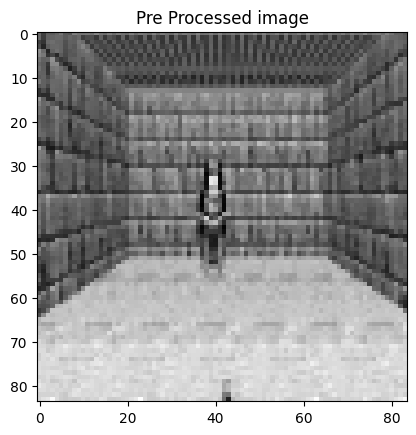

In [7]:
game.init()
plt.figure()
plt.imshow(preprocess_frame(game.get_state().screen_buffer.transpose(1, 2, 0),(60, -12, -80, 4), 84), cmap="gray")
game.close()
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [8]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (60, -12, -80, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

## Step 6: Creating our Agent

In [9]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = len(possible_actions)
EPISODES = 5000
skiprate = 12           # how many frames to skip
SEED = 0
ALPHA= 0.001          # Actor learning rate
BETA = 0.005          # Critic learning rate
GAMMA = 0.99           # discount factor
EPSILON = 1.0          # for epsilon-greedy action selection
EPSILON_DECAY = 0.9995 # decay rate for epsilon
EPSILON_MIN = 0.05     # minimum value of epsilon
UPDATE_EVERY = 250     # how often to update the network 
actor_savefile = "models/basic/actor.pth"
critic_savefile = "models/basic/critic.pth"
best_actor_savefile= "models/basic/best_actor_.pth"
best_critic_savefile = "models/basic/best_critic_.pth"
train_model = True
save_model = False
load_model = True
save_best_model = True

agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY)

## Step 7: Watching untrained agent play

In [10]:
# watch an untrained agent
game.init()
score = 0
state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _, _= agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  -106.0


## Step 8: Loading Agent

In [11]:
agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY,
                 epsilon=EPSILON, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN,
                 load_model=load_model, actor_model=actor_savefile, critic_model=critic_savefile)

Loading model from checkpoint
No model checkpoint found


## Step 9: Train the Agent with Advantage Actor Critic (A2C)

In [12]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    #best score of the entire run
    best_score=0
    #Start with episode 0
    start_episode = 0 
    # a list with all the score of every episode.
    scores = []
    #interface of the training, not visibile (False) to train fast
    game.set_window_visible(False)
    # initializes the enviroment for VizDoom
    game.init()
    
    #starts from the episode 1 to episode 10.000 (setted as iperparameters)
    for i_episode in range(start_episode + 1, n_episodes+1):
        game.new_episode()
        
        state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
        score = 0
        while True:
            #take the action (move left, move right, attack), the log_prob (the probability to do a determinate action for the agent state), 
            #the entropy to minimize the accuracy of the probability.
            action, log_prob, entropy = agent.act(state)
            
            #Reward is the score of the action i in the episode i
            reward = game.make_action(possible_actions[action], skiprate)
            #after reward calculated, we have to check if the episode is currently finished (or the player kill the enemy, or timeout 300 tics)
            done = game.is_episode_finished()
            #the current score is the sum of the current reward.
            score += reward
            #when the episode i is finished it is time to run the i+1 episode
            if done:
                break
            #otherwise, (it is meaning the episode is not finished in the good way)
            else:
                #it is time to take another state (so another action), and repeat the all while, untile the done is True.
                next_state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
                agent.step(state, log_prob, entropy, reward, done, next_state)
                state = next_state
        #when done is True it is time to add the current score in the scores list.         
        scores.append(score)
                      
                    
        print('\rEpisode {}\tScore: {},\tAverage Score: {:.2f},\tEpsilon: {:.4f},\tLoss: {:.4f}'.format(i_episode, score, np.mean(scores), agent.epsilon, agent.loss), end="")
        #if we are in the multiple episode 1000 and save_model, a parameter to save the actual model to other training.
        if save_model and i_episode % 1000 == 0:
            actor_savefile = "models/basic/actor_{}.pth".format(i_episode)
            critic_savefile = "models/basic/critic_{}.pth".format(i_episode)
            print("\nSaving the networks to file: ", actor_savefile, critic_savefile)
            torch.save(agent.actor_net, actor_savefile)
            torch.save(agent.critic_net, critic_savefile)
        #method to took the best model with the best scores of the entire run.
        if save_best_model and i_episode%100 == 0:
            last_100_ep = scores[-100:]
            mean_100 = sum(last_100_ep)/len(last_100_ep)
            if mean_100>best_score:
                best_score=mean_100
                print("\nSaving the networks to file: ", best_actor_savefile, best_critic_savefile)
                torch.save(agent.actor_net, best_actor_savefile)
                torch.save(agent.critic_net, best_critic_savefile)
    game.close()
    
    
    
    if save_model:
        torch.save(agent.actor_net, "models/basic/actor.pth")
        torch.save(agent.critic_net, "models/basic/critic.pth")
        
    return scores

In [13]:
if train_model:    
    scores = train(EPISODES)

Episode 5000	Score: 95.0,	Average Score: -74.88,	Epsilon: 0.0500,	Loss: 2215.0567673

## Step 10: Watch a Smart Agent!

In [14]:
# watch a trained agent
for i in range(10):
    game.init()
    score = 0
    state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
    while True:
        action, _, _= agent.act(state)
        score += game.make_action(possible_actions[action])
        done = game.is_episode_finished()
        if done:
            print("Your total score is: ", score)
            break
        else:
            state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
            
    game.close()

Your total score is:  -405.0
Your total score is:  -405.0
Your total score is:  -133.0
Your total score is:  95.0
Your total score is:  94.0
Your total score is:  -405.0
Your total score is:  -410.0
Your total score is:  95.0
Your total score is:  95.0
Your total score is:  95.0


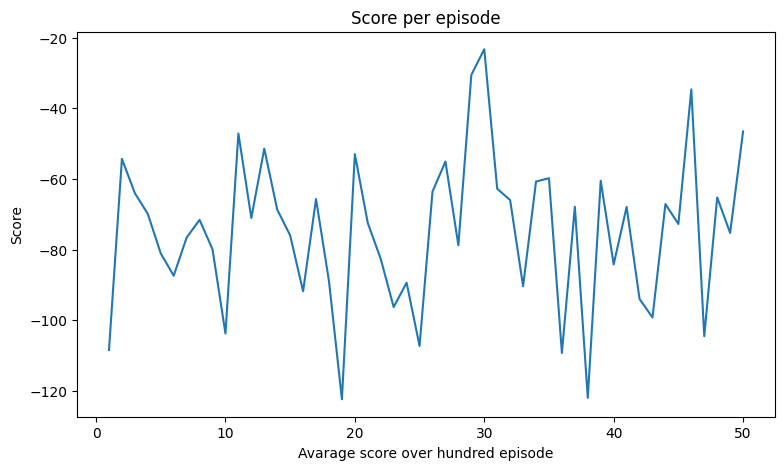

In [15]:
#graphic

#list_mean, where its elements are the mean of every 100 elements of the original list: scores 
list_mean = []

for i in range(0, len(scores), 100):
    block_of_100 = scores[i:i+100]
    mean_of_block =  sum(block_of_100)/ len(block_of_100)
    list_mean.append(mean_of_block)
    
plt.figure(figsize=(9,5))
plt.title("Score per episode")
plt.xlabel("Avarage score over hundred episode")
plt.ylabel("Score")
plt.plot(np.arange(1,len(list_mean)+1), list_mean)




In [19]:
#The best episode of the entire run
best_agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY,
                 load_model=True, actor_model=best_actor_savefile, critic_model=best_critic_savefile)

game.set_window_visible(True)

for i in range(10):
    game.init()
    score = 0
    state = stack_frames(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
    while True:
        action, _, _= agent.act(state)
        score += game.make_action(possible_actions[action])
        done = game.is_episode_finished()
        if done:
            print("Your total score is: ", score)
            break
        else:
            state = stack_frames(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
            
    game.close()

Loading model from checkpoint
No model checkpoint found
Your total score is:  -405.0
Your total score is:  95.0
Your total score is:  95.0
Your total score is:  -410.0
Your total score is:  95.0
Your total score is:  95.0
Your total score is:  95.0
Your total score is:  95.0
Your total score is:  -405.0
Your total score is:  95.0
